# Results for EDM 2019 submission

Commonly used methods are defined and documented in the `functions.py` file. We import them here and use them throughout this document. 

In [1]:
from functions import *
warnings.simplefilter('ignore')
%matplotlib inline

## Data Processing

### Activity Features

The calculated activity features are in the file `Data/ActivityFeatures_Unscaled_1718SchoolYear.csv`. Each instance is a 5-minute window of activity preceding a survey answer, so there may be multiple instances per student. This data was created in previous work so the process is not shown here.

First, we remove unnecessary features. Then, we rescale the appropriate survey responses so all responses are in the range of $[1,5]$. The survey states that need to be rescaled are Arousal, Mind Wandering, and Pleasantness.

In [2]:
# Load original data
activity_old = readData('Data/ActivityFeatures_Unscaled_1718SchoolYear.csv')
# Remove unecessary columns
activity_old = dropColumns(activity_old,['survey_id','time_window','question_id'])
# Fit a scaler to map [1,7] to [1,5]
survey_scaler = MinMaxScaler(feature_range=(1,5))
# Scale and replace for each of the survey states
for state in ['Arousal','Mind Wandering','Pleasantness']:
    # Get responses for the state
    unscaled = activity_old.loc[activity_old['survey_question'] == state]['survey_answer']
    # Scale to [1,5]
    scaled = pd.Series(survey_scaler.fit_transform(unscaled.values.reshape(-1,1)).reshape(len(unscaled)),index = unscaled.index)
    # Replace values
    activity_old.loc[activity_old['survey_question'] == state, ['survey_answer']] = scaled

We will then save this to `Data/ActivityFeatures_Scaled_1718SchoolYear.csv` and use these features.

In [3]:
activity_old.to_csv('Data/ActivityFeatures_Scaled_1718SchoolYear.csv')

In [4]:
activity_features = readData('Data/ActivityFeatures_Scaled_1718SchoolYear.csv')

### Usage Features
The calculated usage features are in the file `Data/UsageFeatures_Unprocessed_1718SchoolYear.csv`. Each instance is the summary data for one student, so each student only has one instance.

We first replace outliers in the `sessionTime` and `NumSessions` features with the 99th percentile value.

In [5]:
# Load original usage features
usage_old = readData('Data/UsageFeatures_Unprocessed_1718SchoolYear.csv')

# Replace with 99th percentile value
usage_old = replaceOutliers(usage_old,['sessionTime','NumSessions'])

We then scale each column to lie in $[0,1]$.

In [6]:
# Scale columns
usage_old, scalers = scaleColumns(usage_old)

We will then save this to `Data/UsageFeatures_Processed_1718SchoolYear.csv` and use these features.

In [7]:
usage_old.to_csv('Data/UsageFeatures_Processed_1718SchoolYear.csv')

In [8]:
usage_features = readData('Data/UsageFeatures_Processed_1718SchoolYear.csv')

### Demographic Features
The recorded demographic features are in the file `Data/DemographicFeatures_DOE_1718SchoolYear.csv`. Each instance is the recorded data for one student and each student only has one instance.

These codes are in the original categories given by the Department of Education. We will relabel the lunch codes to simplify the groups. The lunch codes can be found [here](http://www.fldoe.org/core/fileparse.php/18496/urlt/1718-146025.pdf)

In [9]:
# Load data with original DOE codes
demographics_old = readData('Data/DemographicFeatures_DOE_1718SchoolYear.csv')

# Replace lunch codes
demographics_old.loc[demographics_old['lunch_status']== 'N',['lunch_status']] = 'Other'
demographics_old.loc[demographics_old['lunch_status']== '0',['lunch_status']] = 'Other'
demographics_old.loc[demographics_old['lunch_status']== '1',['lunch_status']] = 'Other'
demographics_old.loc[demographics_old['lunch_status']== '4',['lunch_status']] = 'Other'
demographics_old.loc[demographics_old['lunch_status']== 'R',['lunch_status']] = 'Reduced'
demographics_old.loc[demographics_old['lunch_status']== 'E',['lunch_status']] = 'Reduced'
demographics_old.loc[demographics_old['lunch_status']== '3',['lunch_status']] = 'Reduced'
demographics_old.loc[demographics_old['lunch_status']== 'C',['lunch_status']] = 'Free'
demographics_old.loc[demographics_old['lunch_status']== 'F',['lunch_status']] = 'Free'
demographics_old.loc[demographics_old['lunch_status']== 'D',['lunch_status']] = 'Free'

We saved these features to `Data/DemographicFeatures_Simplified_1718SchoolYear.csv`

In [10]:
demographics_old.to_csv('Data/DemographicFeatures_Simplified_1718SchoolYear.csv')

We then converted these categorical features to binary features. This was done in Microsoft Excel and can be found in the file `Data/DemographicFeatures_Binary_1718SchoolYear.csv`. We will use these features.

In [11]:
demographics_features = readData('Data/DemographicFeatures_Binary_1718SchoolYear.csv')

### Define Attributes and Groups
After cleaning the above data, we define the groups within the attributes we want to study. Groups are defined as a binary index that can be used to filter dataframes.

In [12]:
# Female students
femaleIndex = demographics_features.loc[demographics_features['Female'] == 1].index
# Male students
maleIndex = demographics_features.loc[demographics_features['Female'] == 0].index


# F/R lunch students
freereducedIndex = pd.concat([demographics_features.loc[demographics_features['Free Lunch'] == 1],
                              demographics_features.loc[demographics_features['Reduced Lunch'] == 1]]).sort_index().index
# Other lunch students
otherlunchIndex = demographics_features.loc[demographics_features['Other Lunch'] == 1].index


# Middle school students
middleschoolIndex = pd.concat([demographics_features.loc[demographics_features['Grade 6'] == 1],
                               demographics_features.loc[demographics_features['Grade 7'] == 1],
                               demographics_features.loc[demographics_features['Grade 8'] == 1]]).sort_index().index
# 9th grade students
grade9Index = demographics_features.loc[demographics_features['Grade 9'] == 1].index
# High school students
highschoolIndex = pd.concat([demographics_features.loc[demographics_features['Grade 10'] == 1],
                             demographics_features.loc[demographics_features['Grade 11'] == 1],
                             demographics_features.loc[demographics_features['Grade 12'] == 1]]).sort_index().index

# White students
whiteIndex = demographics_features.loc[demographics_features['White'] == 1].index
# Black students
blackIndex = demographics_features.loc[demographics_features['Black'] == 1].index
# Hispanic students
hispanicIndex = demographics_features.loc[demographics_features['Hispanic'] == 1].index
# Other race students
otherraceIndex = pd.concat([demographics_features.loc[demographics_features['Native American'] == 1],
                            demographics_features.loc[demographics_features['Asian'] == 1],
                            demographics_features.loc[demographics_features['Pacific Islander'] == 1]]).sort_index().index

We will filter our activity features so that we only include students that have reported demographic information. This defines the All group features.

In [13]:
demographics_features = filterByIndex(demographics_features,activity_features.index)
featuresAll = filterByIndex(activity_features,demographics_features.index)
allIndex = featuresAll.index

Define feature and label sets for positive and negative states. The positive states are Arousal, Contentment, Engagement, Happiness, Hopefulness, Interest, Pleasantness, Pride, and Relief. The negative states are Anxiety, Boredom, Confusion, Disappointment, Frustration, Mind Wandering, and Sadness.

In [14]:
# Create feature sets for positive (P) and negative (N)
featuresP = pd.concat([featuresAll.loc[featuresAll['survey_question']=='Happiness'],
                        featuresAll.loc[featuresAll['survey_question']=='Hopefulness'],
                        featuresAll.loc[featuresAll['survey_question']=='Contentment'],
                        featuresAll.loc[featuresAll['survey_question']=='Relief'],
                        featuresAll.loc[featuresAll['survey_question']=='Pride'],
                        featuresAll.loc[featuresAll['survey_question']=='Pleasantness'],
                        featuresAll.loc[featuresAll['survey_question']=='Interest'],
                        featuresAll.loc[featuresAll['survey_question']=='Arousal'],
                        featuresAll.loc[featuresAll['survey_question']=='Engagement']]).sort_index()
featuresN = pd.concat([featuresAll.loc[featuresAll['survey_question']=='Frustration'],
                        featuresAll.loc[featuresAll['survey_question']=='Confusion'],
                        featuresAll.loc[featuresAll['survey_question']=='Disappointment'],
                        featuresAll.loc[featuresAll['survey_question']=='Anxiety'],
                        featuresAll.loc[featuresAll['survey_question']=='Sadness'],
                        featuresAll.loc[featuresAll['survey_question']=='Mind Wandering'],
                        featuresAll.loc[featuresAll['survey_question']=='Boredom']]).sort_index()

# Create label sets and discard this information from feature sets
labelsP = featuresP['survey_answer']
featuresP = dropColumns(featuresP,['survey_answer','survey_question'])

labelsN = featuresN['survey_answer']
featuresN = dropColumns(featuresN,['survey_answer','survey_question'])

labelsAll = featuresAll['survey_answer']
featuresAll = dropColumns(featuresAll,['survey_answer','survey_question'])

## Clustering

### Usage Clusters

First, take a sample of 1,000 instances from usage features

In [15]:
usage_sample = getSample(usage_features,1000)

Then train a Ward hierarchical clustering model and display the dendrogram to determine the number of clusters.

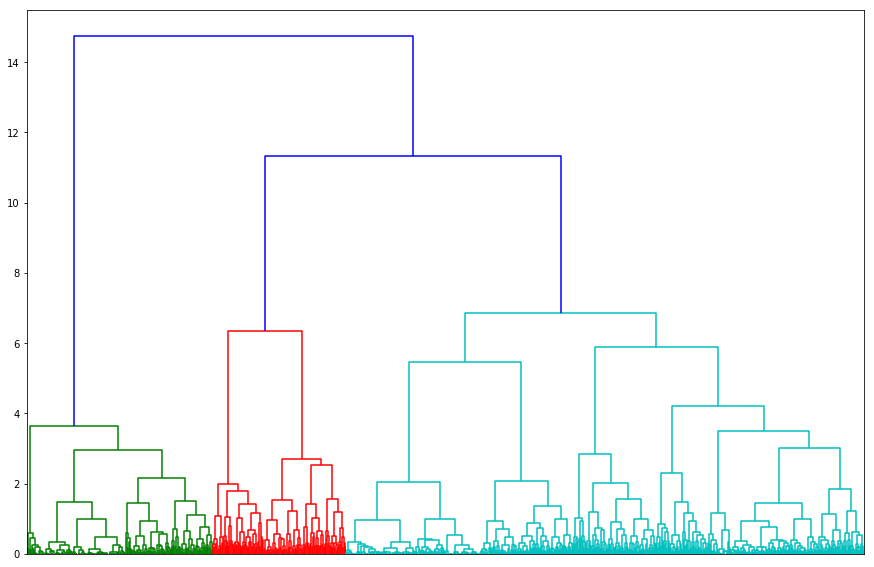

In [16]:
# train model
wardUsageClusters = linkage(usage_sample,method='ward')
# display the results
plt.figure(figsize=(15,10))
_ = dendrogram(wardUsageClusters,no_labels=True,p=15,truncate_mode='level')

This suggests that truncating at five clusters is a good option.

We then train a k-means model with $k=5$ clusters. To get the same results as the paper, we will also load the pre-trained model that is saved as `Data/UsageClusters.joblib`. We train the model with all students in the usage dataset. The resulting table is Table 1 in the paper.

In [ ]:
# If you were to train from scratch

# create an algorithm instance
kmeansUsage = KMeans(n_clusters=5)
# train the model
kmeansUsageLabels, kmeansUsageModel = cluster(kmeansUsage, usage_features)
# get the cluster centers
kmeansUsageCenters = kmeansUsageModel.cluster_centers_
# rescale the features
kmeansUsageCentersUnscaled = reverseScale(pd.DataFrame(data=kmeansUsageCenters,columns=getColumnLabels(usage_features)), scalers)
# display a summary of the cluster centers
displayClusters(kmeansUsageLabels.values,kmeansUsageCenters,getColumnLabels(usage_features))

,desktop,spring,hour,sessionTime,NumSessions,Proportions
0,0.99,0.11,14.81,13.80,3.46,0.28
1,0.99,0.96,14.86,14.41,3.55,0.35
2,0.90,0.75,14.19,45.45,25.59,0.20
3,0.27,0.93,13.21,29.69,10.95,0.10
4,0.30,0.19,13.25,21.36,9.50,0.07


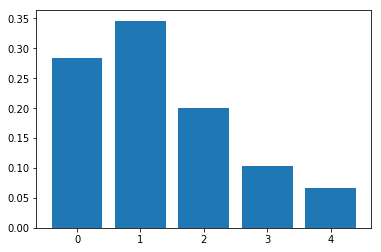

In [17]:
# If you want to replicate results

# Load a pre-trained model so that we get the same results
kmeansUsage = joblib.load('Data/UsageClusters.joblib')
# get the cluster centers
kmeansUsageCenters = kmeansUsage.cluster_centers_
# generate predicted clusters for each student
kmeansUsageLabels = pd.Series(kmeansUsage.predict(usage_features.values),index=usage_features.index)
# rescale the features
kmeansUsageCentersUnscaled = reverseScale(pd.DataFrame(data=kmeansUsageCenters,columns=getColumnLabels(usage_features)), scalers)
# display a summary of the cluster centers
displayClusters(kmeansUsageLabels.values,kmeansUsageCentersUnscaled.values,getColumnLabels(usage_features))

Save the indices of the clusters for the supervised learning section. The clusters are labeled as follows:
> 0 - Fall, light use
>
> 1 - Spring, light use
>
> 2 - Fall, mobile
>
> 3 - Spring, mobile
>
> 4 - Spring, heavy use

In [18]:
useC0Index = kmeansUsageLabels.loc[kmeansUsageLabels == 0].index
useC1Index = kmeansUsageLabels.loc[kmeansUsageLabels == 1].index
useC2Index = kmeansUsageLabels.loc[kmeansUsageLabels == 2].index
useC3Index = kmeansUsageLabels.loc[kmeansUsageLabels == 3].index
useC4Index = kmeansUsageLabels.loc[kmeansUsageLabels == 4].index

For computing the out-group metric, we define the Other groups.

In [19]:
useOut4Index = useC0Index.union(useC1Index).union(useC2Index).union(useC3Index)
useOut1Index = useC0Index.union(useC4Index).union(useC2Index).union(useC3Index)
useOut2Index = useC0Index.union(useC1Index).union(useC4Index).union(useC3Index)
useOut3Index = useC0Index.union(useC1Index).union(useC2Index).union(useC4Index)
useOut0Index = useC4Index.union(useC1Index).union(useC2Index).union(useC3Index)

### Demographic Clusters

First, take a sample of 1,000 instances from demographics features

In [23]:
demographics_sample = getSample(demographics_features,1000)

Then train a Ward hierarchical clustering model and display the dendrogram to determine the number of clusters.

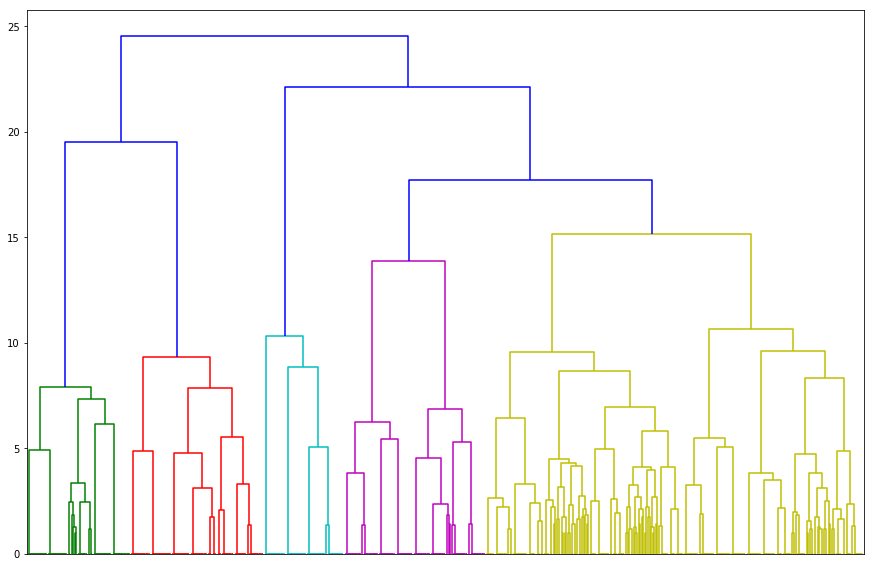

In [24]:
# train model
wardDemographicsClusters = linkage(demographics_sample,method='ward')
# display the results
plt.figure(figsize=(15,10))
_ = dendrogram(wardDemographicsClusters,no_labels=True,p=15,truncate_mode='level')

This suggests truncating at seven clusters is a good option.

We then train a k-means model with $k=7$ clusters. To get the same results as the paper, we load the pre-trained model found in `Data/DemographicClusters.joblib`. We train the model with all students with demographic information. The resulting table is Table 2 in the paper.

In [ ]:
# If you were to train from scratch

# create an algorithm instance
kmeansDemographics = KMeans(n_clusters=7)
# train the model
kmeansDemographicsLabels, kmeansDemographicseModel = cluster(kmeansDemographics, demographics_features)
# get the cluster centers
kmeansDemographicsCenters = kmeansDemographicsModel.cluster_centers_
# display a summary of the cluster centers
displayClusters(kmeansDemographicsLabels.values,kmeansDemographicsCenters,getColumnLabels(demographics_features))

,Grade 6,Grade 7,Grade 8,Grade 9,Grade 10,Grade 11,Grade 12,Free Lunch,Reduced Lunch,Other Lunch,Hispanic,Native American,Asian,Black,Pacific Islander,White,Mixed,Female,Proportions
0,0.0,-0.00,-0.00,0.00,1.00,0.00,0.00,0.47,0.05,0.48,0.41,0.05,0.03,0.20,0.01,0.76,0.04,0.47,0.04
1,0.0,0.00,1.00,-0.00,-0.00,0.00,0.00,0.91,0.09,0.00,0.52,0.06,0.06,0.03,0.01,0.90,0.04,0.51,0.16
2,0.0,0.08,0.29,0.44,0.17,0.02,0.01,0.97,0.03,0.01,0.04,0.00,0.01,1.00,0.00,0.03,0.04,0.53,0.15
3,0.0,0.00,0.99,-0.00,-0.00,0.00,0.00,-0.00,0.00,1.00,0.21,0.02,0.07,0.09,0.01,0.87,0.04,0.53,0.25
4,0.0,0.00,0.00,0.99,-0.00,0.01,0.00,-0.00,0.04,0.96,0.27,0.03,0.04,0.16,0.01,0.81,0.03,0.51,0.14
5,0.0,1.00,-0.00,0.00,0.00,0.00,0.00,0.16,0.04,0.80,0.18,0.01,0.16,0.06,0.01,0.80,0.04,0.50,0.12
6,0.0,0.11,0.00,0.87,-0.00,0.01,0.00,0.97,0.03,0.00,0.67,0.07,0.03,0.01,0.01,0.91,0.01,0.50,0.14


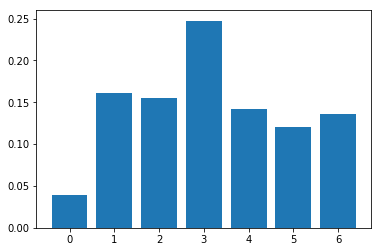

In [25]:
# If you want to replicate results

# Load a pre-trained model so that we get the same results
kmeansDemographics = joblib.load('Data/DemographicClusters.joblib')
# get the cluster centers
kmeansDemographicsCenters = kmeansDemographics.cluster_centers_
# generate predicted clusters for each student
kmeansDemographicsLabels = pd.Series(kmeansDemographics.predict(demographics_features.values),index=demographics_features.index)
# display a summary of the cluster centers
displayClusters(kmeansDemographicsLabels.values,kmeansDemographicsCenters,getColumnLabels(demographics_features))

We will then save the clusters as groups for the supervised learning section. The clusters are labeled as follows:

> 0 - Split grades, F/R lunch, Black
>
> 1 - Grade 7, not F/R lunch, White/Asian
>
> 2 - Grade 8, not F/R lunch, White
>
> 3 - Grade 8, F/R lunch, White
>
> 4 - Grade 9, F/R lunch, White
>
> 5 - Grade 9, not F/R lunch, White/Black
>
> 6 - Grade 10, split lunch, White/Black


In [26]:
demographicsC0Index = kmeansDemographicsLabels.loc[kmeansDemographicsLabels == 0].index
demographicsC1Index = kmeansDemographicsLabels.loc[kmeansDemographicsLabels == 1].index
demographicsC2Index = kmeansDemographicsLabels.loc[kmeansDemographicsLabels == 2].index
demographicsC3Index = kmeansDemographicsLabels.loc[kmeansDemographicsLabels == 3].index
demographicsC4Index = kmeansDemographicsLabels.loc[kmeansDemographicsLabels == 4].index
demographicsC5Index = kmeansDemographicsLabels.loc[kmeansDemographicsLabels == 5].index
demographicsC6Index = kmeansDemographicsLabels.loc[kmeansDemographicsLabels == 6].index

For calculating the out-group metric, we define the Other groups

In [27]:
demoOut6Index = demographicsC0Index.union(demographicsC1Index).union(demographicsC2Index).union(demographicsC3Index).union(demographicsC4Index).union(demographicsC5Index)
demoOut5Index = demographicsC0Index.union(demographicsC1Index).union(demographicsC2Index).union(demographicsC3Index).union(demographicsC4Index).union(demographicsC6Index)
demoOut4Index = demographicsC0Index.union(demographicsC1Index).union(demographicsC2Index).union(demographicsC3Index).union(demographicsC6Index).union(demographicsC5Index)
demoOut3Index = demographicsC0Index.union(demographicsC1Index).union(demographicsC2Index).union(demographicsC6Index).union(demographicsC4Index).union(demographicsC5Index)
demoOut2Index = demographicsC0Index.union(demographicsC1Index).union(demographicsC6Index).union(demographicsC3Index).union(demographicsC4Index).union(demographicsC5Index)
demoOut1Index = demographicsC0Index.union(demographicsC6Index).union(demographicsC2Index).union(demographicsC3Index).union(demographicsC4Index).union(demographicsC5Index)
demoOut0Index = demographicsC6Index.union(demographicsC1Index).union(demographicsC2Index).union(demographicsC3Index).union(demographicsC4Index).union(demographicsC5Index)

## Basic Models

### Generalizability

Define a dictionary of the group indices and labels for each attribute

In [28]:
indexDict = {'gender'      : [[femaleIndex,maleIndex,allIndex],['Female','Male','All']], 
            'lunch status' : [[freereducedIndex,otherlunchIndex,allIndex],['F/R','Other','All']],
            'grade level'  : [[middleschoolIndex,grade9Index,highschoolIndex,allIndex],['Middle School','Grade 9','High School','All']],
            'race'         : [[whiteIndex,blackIndex,hispanicIndex,otherraceIndex,allIndex],['White','Black','Hispanic','Other','All']],
            'usage'        : [[useC0Index,useC1Index,useC2Index,useC3Index,useC4Index,allIndex],['C0','C1','C2','C3','C4','All']],
            'demographics' : [[demographicsC0Index,demographicsC1Index,demographicsC2Index,demographicsC3Index,demographicsC4Index,demographicsC5Index,demographicsC6Index,allIndex],['C0','C1','C2','C3','C4','C5','C6','All']]}

We define a function that will generate the initial generalizability analysis of train on one group and test on the other groups. The input is one of the keys of the dictionary of group indices. This function will generate Tables 3 and 4 in the paper. Note there will be some variation due to the random nature of the algorithm.

In [29]:
def generalizability(attribute):
    # Get data
    groupIndices = indexDict[attribute][0]
    groupLabels = indexDict[attribute][1]
    stateFeatures = [featuresP,featuresN]
    stateLabels = [labelsP,labelsN]
    
    # Allocate space for scores
    correlationP = np.zeros((len(groupIndices),len(groupIndices)))
    correlationN = correlationP.copy()
    scores = [correlationP,correlationN]
    
    # Repeat for positive and negative
    for state in range(len(stateFeatures)):
        # Repeat for each training group
        for trainGroup in range(len(groupIndices)):
            features = filterByIndex(stateFeatures[state],groupIndices[trainGroup])
            ids = features.index.values
            features = features.values
            labels = filterByIndex(stateLabels[state],groupIndices[trainGroup]).values
            
            # Store temporary scores before averaging
            nFolds = 10
            tempCorrelation = np.zeros((nFolds,len(groupIndices)))
            
            # Repeat for each fold
            for i, (train, test) in enumerate(GroupKFold(n_splits=nFolds).split(features,labels,ids)):
                # Train a model
                _, model = classify(features[train],labels[train],features[test])
                
                # Generate predictions for each group
                for testGroup in range(len(groupIndices)):
                    predFeatures = filterByIndex(stateFeatures[state],groupIndices[testGroup]).values
                    predLabels = filterByIndex(stateLabels[state],groupIndices[testGroup]).values
                    predictions = model.predict(predFeatures)
                    tempCorrelation[i,testGroup] = evaluateSpearman(predLabels,predictions)
                    
            # Average across folds
            scores[state][trainGroup,:] = np.mean(tempCorrelation,axis=0)
    
    # Format results
    index = ['Train ' + group for group in groupLabels]
    columns = ['Test ' + group for group in groupLabels]
    return {'correlationP' : pd.DataFrame(correlationP,index=index,columns=columns),
            'correlationN' : pd.DataFrame(correlationN,index=index,columns=columns)}

#### Example of using the function

In [30]:
scoresUsage = generalizability('usage')

In [31]:
scoresUsage['correlationP'].round(2)

,Test C0,Test C1,Test C2,Test C3,Test C4,Test All
Train C0,0.23,0.24,0.20,0.20,0.21,0.22
Train C1,0.22,0.26,0.21,0.22,0.21,0.22
Train C2,0.21,0.25,0.21,0.21,0.20,0.22
Train C3,0.21,0.25,0.20,0.24,0.23,0.22
Train C4,0.21,0.23,0.19,0.21,0.25,0.21
Train All,0.22,0.25,0.21,0.22,0.22,0.22


In [32]:
scoresUsage['correlationN'].round(2)

,Test C0,Test C1,Test C2,Test C3,Test C4,Test All
Train C0,0.20,0.21,0.19,0.17,0.17,0.19
Train C1,0.19,0.23,0.20,0.19,0.18,0.20
Train C2,0.19,0.22,0.20,0.19,0.17,0.21
Train C3,0.18,0.22,0.19,0.21,0.17,0.20
Train C4,0.19,0.22,0.19,0.18,0.19,0.20
Train All,0.20,0.22,0.20,0.19,0.18,0.21


### Group metrics

To calculate the in-group metrics, we can use the tables generated in the previous section. To calculate the out-group metrics, we need to train Other models. The following function generates these values. The column convention is `Train/Test` and each row is from one of 10 folds. The in-group and out-group metrics are calculated in the `Data/Group metrics.xlsx` workbook and give Tables 5 and 6 in the paper.

In [33]:
indexDict = {'usage'       : [[useC0Index,useC1Index,useC2Index,useC3Index,useC4Index,useOut0Index,useOut1Index,useOut2Index,useOut3Index,useOut4Index],[useC0Index,useC1Index,useC2Index,useC3Index,useC4Index,useC0Index,useC1Index,useC2Index,useC3Index,useC4Index],['0/0','1/1','2/2','3/3','4/4','O/0','O/1','O/2','O/3','O/4']],
            'demographics' : [[demographicsC0Index,demographicsC1Index,demographicsC2Index,demographicsC3Index,demographicsC4Index,demographicsC5Index,demographicsC6Index,demoOut0Index,demoOut1Index,demoOut2Index,demoOut3Index,demoOut4Index,demoOut5Index,demoOut6Index],[demographicsC0Index,demographicsC1Index,demographicsC2Index,demographicsC3Index,demographicsC4Index,demographicsC5Index,demographicsC6Index,demographicsC0Index,demographicsC1Index,demographicsC2Index,demographicsC3Index,demographicsC4Index,demographicsC5Index,demographicsC6Index],['0/0','1/1','2/2','3/3','4/4','5/5','6/6','O/0','O/1','O/2','O/3','O/4','O/5','O/6']]}

In [34]:
def generalizabilityOut(attribute):
    # Get data
    trainIndices = indexDict[attribute][0]
    testIndices = indexDict[attribute][1]
    trainTestLabels = indexDict[attribute][2]
    stateFeatures = [featuresP,featuresN]
    stateLabels = [labelsP,labelsN]
    
    nFolds = 10
    
    # Allocate space for scores
    correlationP = np.zeros((nFolds,len(trainIndices)))
    correlationN = correlationP.copy()
    
    scores = [correlationP,correlationN]
    
    # Repeat for positive and negative
    for state in range(len(stateFeatures)):
        # Repeat for each training group
        for combo in range(len(trainIndices)):
            features = filterByIndex(stateFeatures[state],trainIndices[combo])
            ids = features.index.values
            features = features.values
            labels = filterByIndex(stateLabels[state],trainIndices[combo]).values
            
            # Repeat for each fold
            for i, (train, test) in enumerate(GroupKFold(n_splits=nFolds).split(features,labels,ids)):
                # Train a model
                _, model = classify(features[train],labels[train],features[test])
                
                predFeatures = filterByIndex(stateFeatures[state],testIndices[combo]).values
                predLabels = filterByIndex(stateLabels[state],testIndices[combo]).values
                predictions = model.predict(predFeatures)
                
                scores[state][i,combo] = evaluateSpearman(predLabels,predictions)
 
    return {'correlationP' : pd.DataFrame(correlationP,columns=trainTestLabels),
            'correlationN' : pd.DataFrame(correlationN,columns=trainTestLabels)}

#### Example of using function

In [35]:
scoresUse = generalizabilityOut('usage')

In [36]:
scoresUse['correlationP'].round(2)

,0/0,1/1,2/2,3/3,4/4,O/0,O/1,O/2,O/3,O/4
0,0.23,0.26,0.21,0.24,0.24,0.22,0.25,0.21,0.21,0.21
1,0.23,0.26,0.21,0.24,0.24,0.22,0.25,0.21,0.22,0.21
2,0.23,0.26,0.21,0.24,0.25,0.22,0.25,0.21,0.21,0.21
3,0.23,0.26,0.21,0.24,0.25,0.22,0.25,0.21,0.21,0.21
4,0.23,0.26,0.21,0.24,0.25,0.22,0.25,0.21,0.21,0.21
5,0.23,0.26,0.21,0.24,0.25,0.22,0.25,0.21,0.21,0.21
6,0.23,0.26,0.21,0.24,0.25,0.22,0.25,0.21,0.21,0.21
7,0.23,0.26,0.21,0.24,0.24,0.22,0.25,0.21,0.21,0.21
8,0.23,0.26,0.21,0.24,0.24,0.22,0.25,0.21,0.21,0.21
9,0.23,0.26,0.21,0.23,0.25,0.22,0.25,0.21,0.21,0.21


#### Graphing the results

This code generates Figure 3 in the paper

In [37]:
dataUse = [['In-group',0.05510,'Positive'],
           ['In-group',0.02474,'Positive'],
           ['In-group',-0.00426,'Positive'],
           ['In-group',0.07704,'Positive'],
           ['In-group',0.13407,'Positive'],
           ['In-group',0.00775,'Negative'],
           ['In-group',0.00649,'Negative'],
           ['In-group',-0.00649,'Negative'],
           ['In-group',0.05746,'Negative'],
           ['In-group',0.05747,'Negative'],
           ['Out-group',-0.05719,'Positive'],
           ['Out-group',-0.03076,'Positive'],
           ['Out-group',-0.01713,'Positive'],
           ['Out-group',-0.10224,'Positive'],
           ['Out-group',-0.14184,'Positive'],
           ['Out-group',-0.02049,'Negative'],
           ['Out-group',-0.01665,'Negative'],
           ['Out-group',-0.01925,'Negative'],
           ['Out-group',-0.06546,'Negative'],
           ['Out-group',-0.05891,'Negative']]
usage = pd.DataFrame(data=dataUse,columns=['Metric','Score','Valence'])

In [38]:
dataDemo = [['In-group',0.04598,'Positive'],
            ['In-group',-0.00484,'Positive'],
            ['In-group',0.00596,'Positive'],
            ['In-group',0.02631,'Positive'],
            ['In-group',0.03361,'Positive'],
            ['In-group',0.04917,'Positive'],
            ['In-group',0.01476,'Positive'],
            ['In-group',0.10296,'Negative'],
            ['In-group',0.04343,'Negative'],
            ['In-group',0.00866,'Negative'],
            ['In-group',0.00748,'Negative'],
            ['In-group',-0.00074,'Negative'],
            ['In-group',0.02286,'Negative'],
            ['In-group',-0.03120,'Negative'],
            ['Out-group',-0.05045,'Positive'],
            ['Out-group',-0.00495,'Positive'],
            ['Out-group',-0.01128,'Positive'],
            ['Out-group',-0.05169,'Positive'],
            ['Out-group',-0.04398,'Positive'],
            ['Out-group',-0.07364,'Positive'],
            ['Out-group',-0.03128,'Positive'],
            ['Out-group',-0.10804,'Negative'],
            ['Out-group',-0.06465,'Negative'],
            ['Out-group',-0.01505,'Negative'],
            ['Out-group',-0.01818,'Negative'],
            ['Out-group',-0.00811,'Negative'],
            ['Out-group',-0.04694,'Negative'],
            ['Out-group',0.02862,'Negative']]
demo = pd.DataFrame(data=dataDemo,columns=['Metric','Score','Valence'])

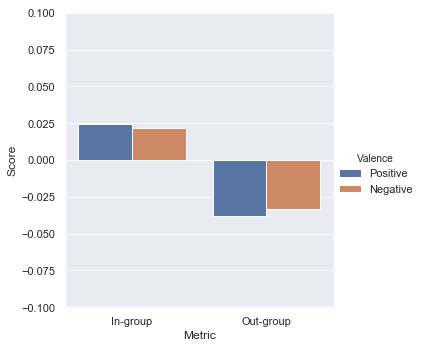

In [39]:
# demographic scores
sns.set()
sns.catplot(x='Metric',y='Score',hue='Valence',kind='bar',ci=None,facet_kws=dict(ylim=(-0.1,0.1)),data=demo)

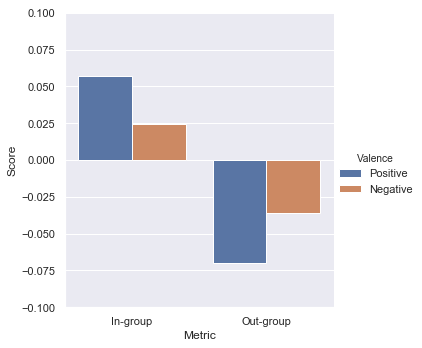

In [40]:
# usage scores
sns.catplot(x='Metric',y='Score',hue='Valence',kind='bar',ci=None,facet_kws=dict(ylim=(-0.1,0.1)),data=usage)

### Predictive Features

We will train a linear regression for each group for positive and negative states. To do this, we will average valence scores for each student. We also scale each feature to $[0,1]$. These averaged files are saved in `Data/averaged valence usage(demographic) clusters.csv`. The file `Data/averaged valence all.csv` contains the data for a general model.

In [41]:
scaledFeaturesP, scalersP = scaleColumns(featuresP)
scaledFeaturesN, scalersN = scaleColumns(featuresN)

In [42]:
clusters = [useC0Index,useC1Index,useC2Index,useC3Index,useC4Index]
first = True
for i in range(len(clusters)):
    pos = filterByIndex(scaledFeaturesP,clusters[i])
    neg = filterByIndex(scaledFeaturesN,clusters[i])
    pos['survey_answer'] = filterByIndex(labelsP,clusters[i])
    neg['survey_answer'] = filterByIndex(labelsN,clusters[i])
    pos = pos.groupby(pos.index).mean()
    neg = neg.groupby(neg.index).mean()
    pos['survey_question'] = 'positive_cluster_'+str(i)
    neg['survey_question'] = 'negative_cluster_'+str(i)
    if first:
        combined = pos.append(neg).sort_index()
        first = False
    else:
        combined = combined.append(pos.append(neg)).sort_index()
    

combined.to_csv('Data/averaged valence usage clusters.csv')

In [43]:
clusters = [demographicsC0Index,demographicsC1Index,demographicsC2Index,demographicsC3Index,demographicsC4Index,demographicsC5Index,demographicsC6Index]
first = True
for i in range(len(clusters)):
    pos = filterByIndex(scaledFeaturesP,clusters[i])
    neg = filterByIndex(scaledFeaturesN,clusters[i])
    pos['survey_answer'] = filterByIndex(labelsP,clusters[i])
    neg['survey_answer'] = filterByIndex(labelsN,clusters[i])
    pos = pos.groupby(pos.index).mean()
    neg = neg.groupby(neg.index).mean()
    pos['survey_question'] = 'positive_cluster_'+str(i)
    neg['survey_question'] = 'negative_cluster_'+str(i)
    if first:
        combined = pos.append(neg).sort_index()
        first = False
    else:
        combined = combined.append(pos.append(neg)).sort_index()
    

combined.to_csv('Data/averaged valence demographic clusters.csv')

In [44]:
pos = filterByIndex(scaledFeaturesP,allIndex)
neg = filterByIndex(scaledFeaturesN,allIndex)
pos['survey_answer'] = filterByIndex(labelsP,allIndex)
neg['survey_answer'] = filterByIndex(labelsN,allIndex)
pos = pos.groupby(pos.index).mean()
neg = neg.groupby(neg.index).mean()
pos['survey_question'] = 'positive_all'
neg['survey_question'] = 'negative_all'
combined = pos.append(neg).sort_index()
combined.to_csv('Data/averaged valence all.csv')

The linear regression which yields Table 7 in the paper is calculated using the R file `adjusted coefficients.R`.

## Sample Size Simulations

This code will produce the data for Figures 4 and 5. The results are stored in `Data/formatted demographic scores.csv` and `Data/formatted usage scores.csv` with columns $sample size,~score,~cluster,~metric,~valence$. This is stored in tidy format so there will be 1000 rows per data point

In [ ]:
# calculate usage scores

nRuns = 1000
traininds = [[useC0Index,allIndex,useOut0Index],
             [useC1Index,allIndex,useOut1Index],
             [useC2Index,allIndex,useOut2Index],
             [useC3Index,allIndex,useOut3Index],
             [useC4Index,allIndex,useOut4Index]]
testinds = [useC0Index,useC1Index,useC2Index,useC3Index,useC4Index]
ends = [[4300,7300,7300,6700,2300],
        [3300,6700,7300,4900,1700]]
statedfs = [featuresP,featuresN]
labelSeries = [labelsP,labelsN]
nFolds = 10
kfold = GroupKFold(n_splits = nFolds)
names = ['Fall,light','Spring,light','Fall,mobile','Spring,mobile','Spring,heavy']
states = ['positive','negative']

for cluster in range(len(traininds)):
    print('Cluster '+str(cluster))
    for valence in range(len(statedfs)):
        print(states[valence])
        for size in range(500,ends[valence][cluster],200):
            print(size)
            for run in range(nRuns):
                predFeatures = filterByIndex(statedfs[valence],testinds[cluster]).values
                predLabels = filterByIndex(labelSeries[valence],testinds[cluster]).values
                
                scores = np.zeros((len(traininds[cluster]),))
                for group in range(len(traininds[cluster])):
                    features = filterByIndex(statedfs[valence],traininds[cluster][group])
                    groups = features.index.values
                    features = features.values
                    labels = filterByIndex(labelSeries[valence],traininds[cluster][group]).values
                    sample = np.random.choice(np.arange(len(labels)),size)
                    features = features[sample]
                    labels = labels[sample]
                    groups = groups[sample]
                    
                    rho = 0
                    for i, (train, test) in enumerate(kfold.split(features,labels,groups)):
                        _, model = classify(features[train],labels[train],features[test])
                        preds = model.predict(predFeatures)
                        rho = rho + evaluateSpearman(predLabels,preds)
                    scores[group] = rho/nFolds
                with open('Data/usage scores.csv','a') as f:
                    wr = csv.writer(f)
                    wr.writerow([size, (scores[0] - scores[1])/scores[1],names[cluster],'in',states[valence]])
                    wr.writerow([size, (scores[2] - scores[0])/scores[0],names[cluster],'out',states[valence]])

Cluster 0
positive
500
700
900
1100
1300
1500
1700


In [21]:
# calculate demographic scores

nRuns = 1000
traininds = [[demographicsC0Index,allIndex,demoOut0Index],
             [demographicsC1Index,allIndex,demoOut1Index],
             [demographicsC2Index,allIndex,demoOut2Index],
             [demographicsC3Index,allIndex,demoOut3Index],
             [demographicsC4Index,allIndex,demoOut4Index],
             [demographicsC5Index,allIndex,demoOut5Index],
             [demographicsC6Index,allIndex,demoOut6Index]]
testinds = [demographicsC0Index,demographicsC1Index,demographicsC2Index,demographicsC3Index,demographicsC4Index,demographicsC5Index,demographicsC6Index]
ends = [[2100,7300,7300,7300,7300,7300,7300],
        [1500,7300,6700,7300,5700,6700,5300]]
statedfs = [featuresP,featuresN]
labelSeries = [labelsP,labelsN]
nFolds = 10
kfold = GroupKFold(n_splits = nFolds)
names = ['F/R,Black','7,White/Asian','8,White','8,F/R,White','9,F/R,White','9,White/Black','10,White/Black']
states = ['positive','negative']

for cluster in range(len(traininds)):
    print('Cluster '+str(cluster))
    for valence in range(len(statedfs)):
        print(states[valence])
        for size in range(500,ends[valence][cluster],200):
            print(size)
            for run in range(nRuns):
                predFeatures = filterByIndex(statedfs[valence],testinds[cluster]).values
                predLabels = filterByIndex(labelSeries[valence],testinds[cluster]).values
                
                scores = np.zeros((len(traininds[cluster]),))
                for group in range(len(traininds[cluster])):
                    features = filterByIndex(statedfs[valence],traininds[cluster][group])
                    groups = features.index.values
                    features = features.values
                    labels = filterByIndex(labelSeries[valence],traininds[cluster][group]).values
                    sample = np.random.choice(np.arange(len(labels)),size)
                    features = features[sample]
                    labels = labels[sample]
                    groups = groups[sample]
                    
                    rho = 0
                    for i, (train, test) in enumerate(kfold.split(features,labels,groups)):
                        _, model = classify(features[train],labels[train],features[test])
                        preds = model.predict(predFeatures)
                        rho = rho + evaluateSpearman(predLabels,preds)
                    scores[group] = rho/nFolds
                with open('Data/demographic scores.csv','a') as f:
                    wr = csv.writer(f)
                    wr.writerow([size, (scores[0] - scores[1])/scores[1],names[cluster],'in',states[valence]])
                    wr.writerow([size, (scores[2] - scores[0])/scores[0],names[cluster],'out',states[valence]])

Cluster 0
positive
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500
2700
2900
3100
3300
3500
3700
3900
4100
4300
4500
4700
4900
5100
5300
5500
5700
5900
6100
6300
6500
6700
6900
7100
negative
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500
2700
2900
3100
3300
3500
3700
3900
4100
4300
4500
4700
4900
5100
5300
5500
Cluster 1
positive
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500
2700
2900
3100
3300
3500
3700
3900
4100
4300
4500
4700
4900
5100
5300
5500
5700
5900
6100
6300
6500
6700
6900
7100
negative
500
700
900
1100
1300
1500
1700
1900
2100
2300
2500
2700
2900
3100
3300
3500
3700
3900
4100
4300
4500
4700
4900
5100
5300
5500
5700
5900
6100
6300
6500
Cluster 2
positive
500
700
900
1100
1300
1500
1700


KeyboardInterrupt: 

### Graphing

In [45]:
demoScores = pd.read_csv('Data/formatted demographic scores.csv')
usageScores = pd.read_csv('Data/formatted usage scores.csv')

In [50]:
demoScores.loc[demoScores['Metric']=='in',['Metric']] = 'In-group'
demoScores.loc[demoScores['Metric']=='out',['Metric']] = 'Out-group'
usageScores.loc[usageScores['Metric']=='in',['Metric']] = 'In-group'
usageScores.loc[usageScores['Metric']=='out',['Metric']] = 'Out-group'


demoScores.loc[demoScores['Cluster']=='F/R,Black',['Cluster']] = 'D1'
demoScores.loc[demoScores['Cluster']=='7,White/Asian',['Cluster']] = 'D2'
demoScores.loc[demoScores['Cluster']=='8,White',['Cluster']] = 'D3'
demoScores.loc[demoScores['Cluster']=='8,F/R,White',['Cluster']] = 'D4'
demoScores.loc[demoScores['Cluster']=='9,F/R,White',['Cluster']] = 'D5'
demoScores.loc[demoScores['Cluster']=='9,White/Black',['Cluster']] = 'D6'
demoScores.loc[demoScores['Cluster']=='10,White/Black',['Cluster']] = 'D7'

usageScores.loc[usageScores['Cluster']=='Spring,heavy',['Cluster']] = 'U1'
usageScores.loc[usageScores['Cluster']=='Spring,light',['Cluster']] = 'U2'
usageScores.loc[usageScores['Cluster']=='Fall,light',['Cluster']] = 'U3'
usageScores.loc[usageScores['Cluster']=='Fall,mobile',['Cluster']] = 'U4'
usageScores.loc[usageScores['Cluster']=='Spring,mobile',['Cluster']] = 'U5'

In [47]:
demoScores.loc[demoScores['Valence']=='positive',['Valence']] = 'pos.'
demoScores.loc[demoScores['Valence']=='negative',['Valence']] = 'neg.'
usageScores.loc[usageScores['Valence']=='positive',['Valence']] = 'pos.'
usageScores.loc[usageScores['Valence']=='negative',['Valence']] = 'neg.'

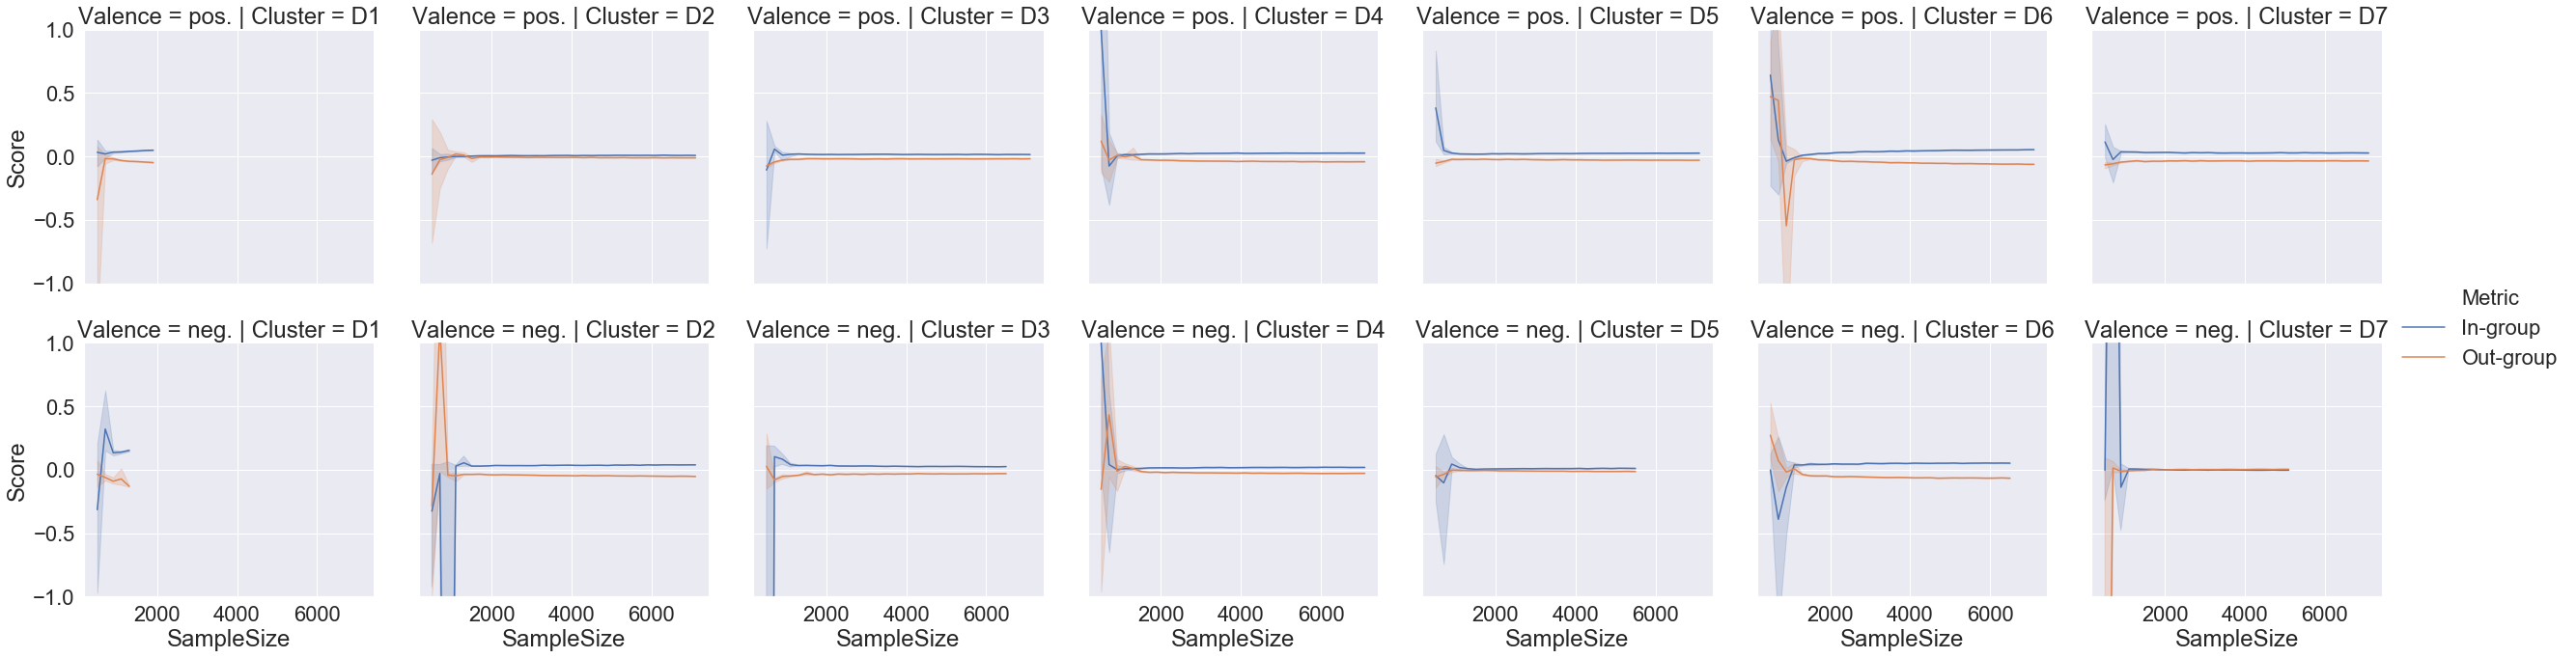

In [48]:
# plot demographic scores
sns.set(font_scale=2)
sns.relplot(x='SampleSize',y='Score',col='Cluster',row='Valence',hue='Metric',kind='line',data=demoScores,facet_kws=dict(ylim=(-1,1)),col_order=['D1','D2','D3','D4','D5','D6','D7'])

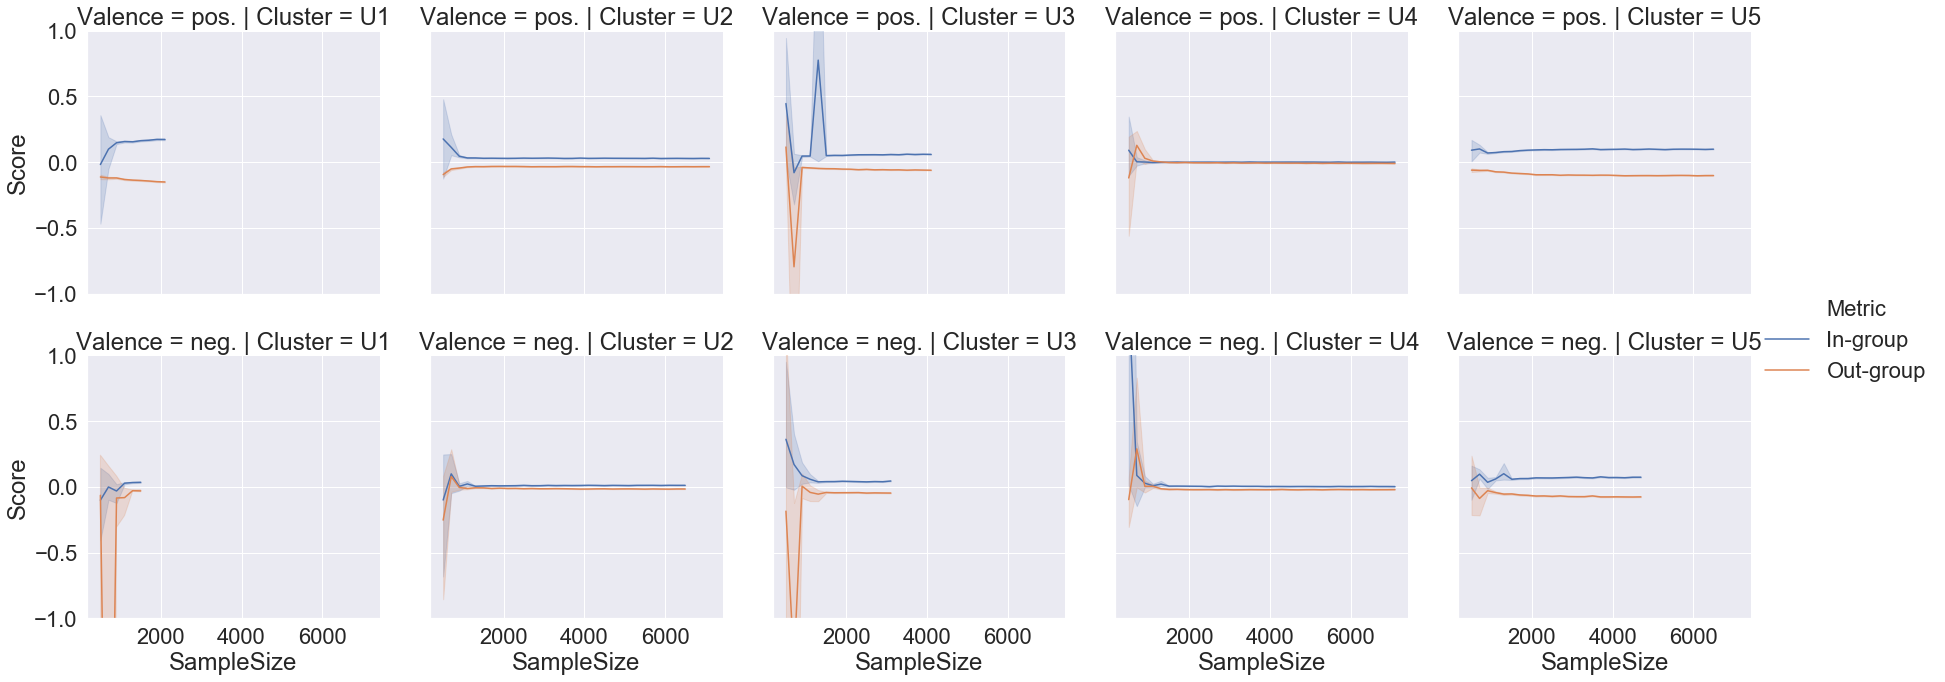

In [51]:
# plot usage scores
sns.relplot(x='SampleSize',y='Score',col='Cluster',row='Valence',hue='Metric',kind='line',data=usageScores,facet_kws=dict(ylim=(-1,1)),col_order=['U1','U2','U3','U4','U5'])